In [1]:
import matplotlib.pyplot as plt

################################
# Solves - u'' + u = f         #
# With zero Dirichlet boundary #
################################
import radiant as rad
import numpy as np


# Problem Parameters
a = 0.
b = 1.


def exact(*x):
    return np.prod(np.sin(np.asarray(x) * 2 * np.pi / (b - a)), axis=0)


def f(*x):
    return (len(x) * (2 * np.pi / (b - a)) ** 2 + 1) * exact(*x)


def g(*x):
    return np.zeros_like(x[0])

In [2]:
# Parameters
d = 1
k = 2
levels = 7
start_delta = 1.5
start_N = 100

# Computed Parameters
ranges = ((a, b),) * d
centre_thinning = 2 ** np.arange(levels)
delta_thinning = 2 ** np.arange(levels)
xcs = [rad.gridinc(ranges, inc, flat=True) for inc in (b - a) / (centre_thinning * (start_N - 1))]
deltas = start_delta / delta_thinning
bndry_eps = 1e-10
idx_funcs = [
    lambda cs: np.all([np.logical_and(np.abs(a - c) > bndry_eps, np.abs(b - c) > bndry_eps) for c in cs], axis=0),
    lambda cs: np.any([np.logical_or(np.abs(a - c) <= bndry_eps, np.abs(b - c) <= bndry_eps) for c in cs], axis=0),
]
operators = [
    lambda func: lambda *x: - func.laplacian(*x) + func(*x),
    lambda func: lambda *x: func(*x),
]

# Integration
error_integrator = rad.integrate.QuadIntegrator(ranges)

# Solve for approximate solution
phis = [rad.Wendland(d, k, delta, xc) for delta, xc in zip(deltas, xcs)]
solver = rad.solve.MultilevelSolver(phis, rad.solve.CollocationSolver, operators, idx_funcs)
approx = solver.solve(f, g)
error = rad.error(exact, approx, error_integrator)

print("L2 Relative Error:", error)
print("Condition Number:", solver.cond())
print("Bandwidth:", solver.bandwidth())

L2 Relative Error: 0.006209370012456488
Condition Number: [6400.759643832849, 34152.99687129768, 922325.0423957855, 336310.4001258104, 22266978.066115633, 58761560.287757955, 227217957.65244436]
Bandwidth: [(99, 99), (148, 148), (148, 148), (148, 148), (148, 148), (148, 148), (148, 148)]


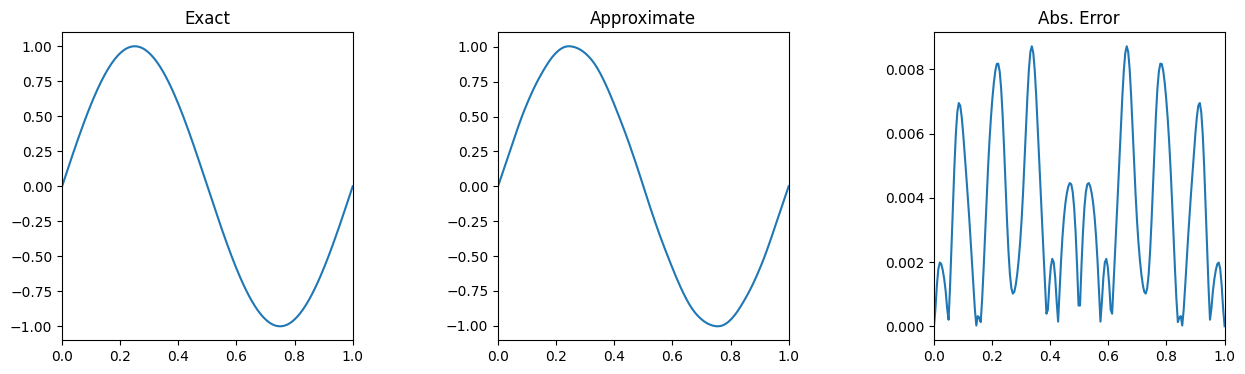

In [3]:
rad.plot.spread(
    ranges,
    exact,
    approx,
    lambda *x: np.abs(exact(*x) - approx(*x )),
    n=200,
    wspace=0.5,
    hspace=0.5,
    titles=["Exact", "Approximate", "Abs. Error"],
    figsize=(15, 4),
)

Once 
 
 Loop 
 
 Reflect

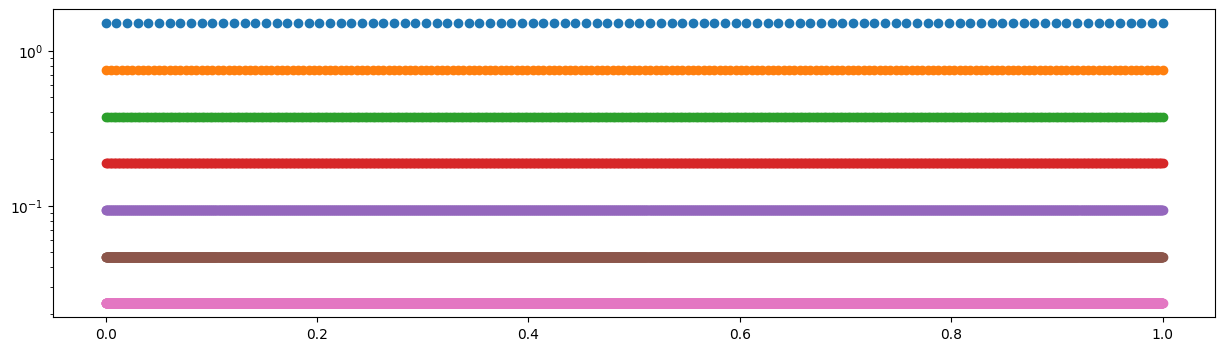

In [4]:
if d == 1:
    from IPython.display import HTML, display_html
    
    
    anim = rad.animate.ml_animate(ranges, exact, approx, n=200, figsize=(10, 4))
    display_html(HTML(anim.to_jshtml()))
    
    rad.plot.thinning(deltas, xcs, d, figsize=(15, 4))

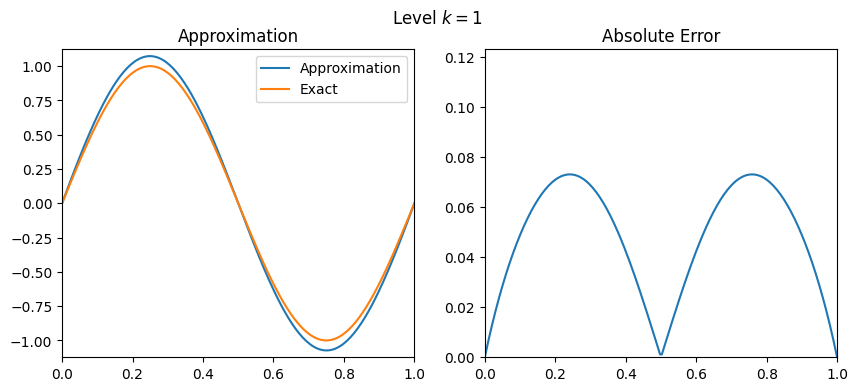

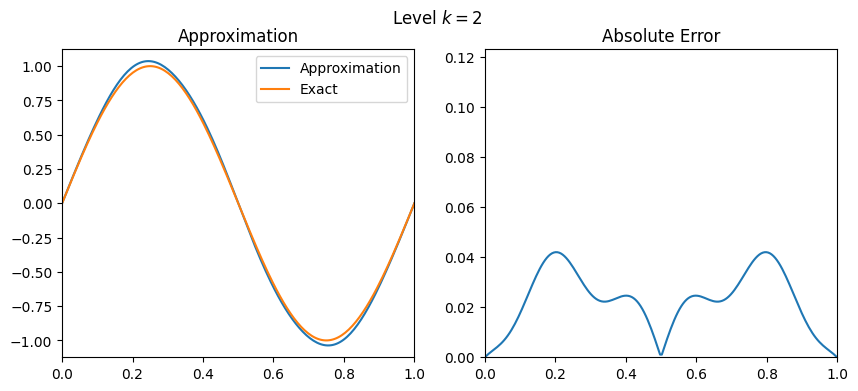

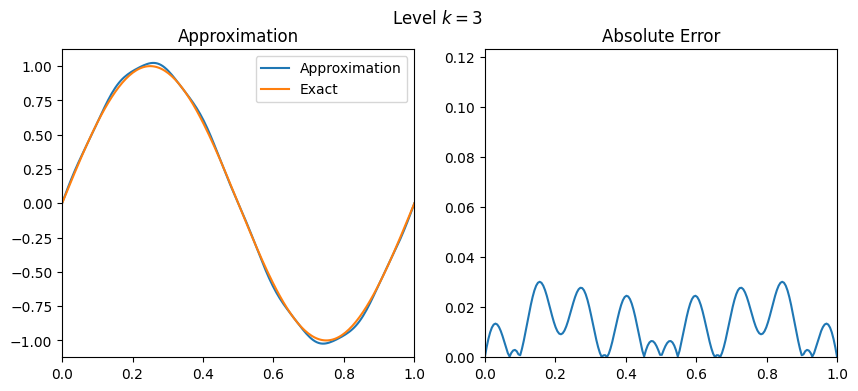

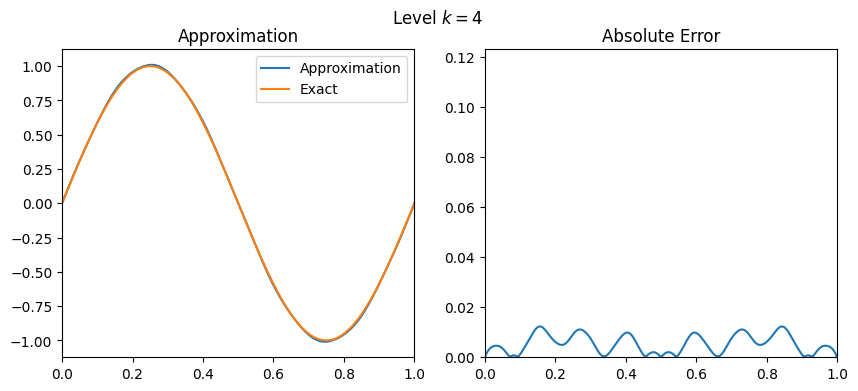

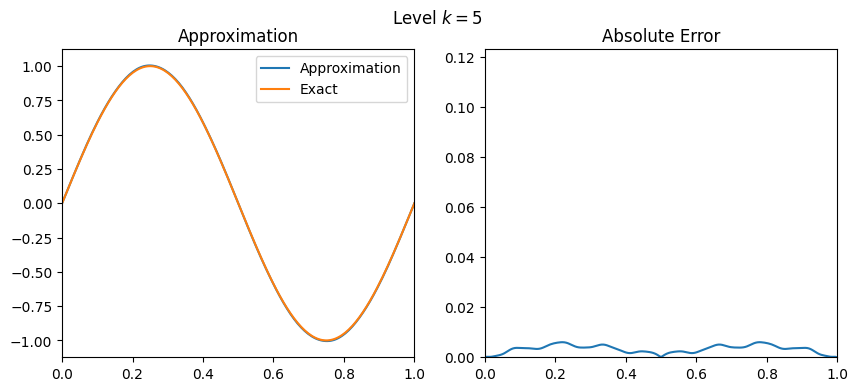

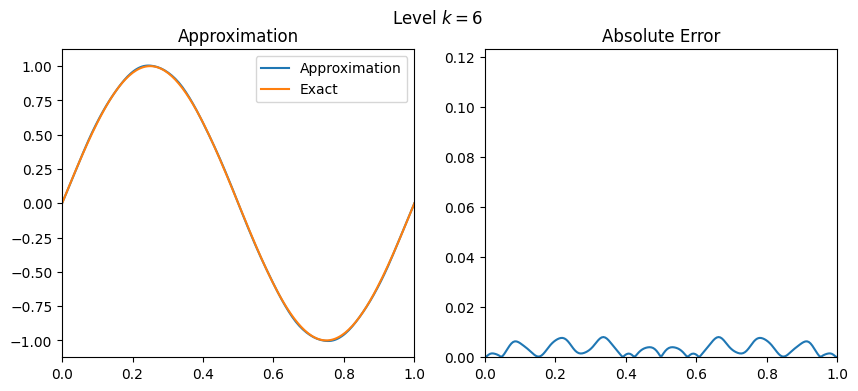

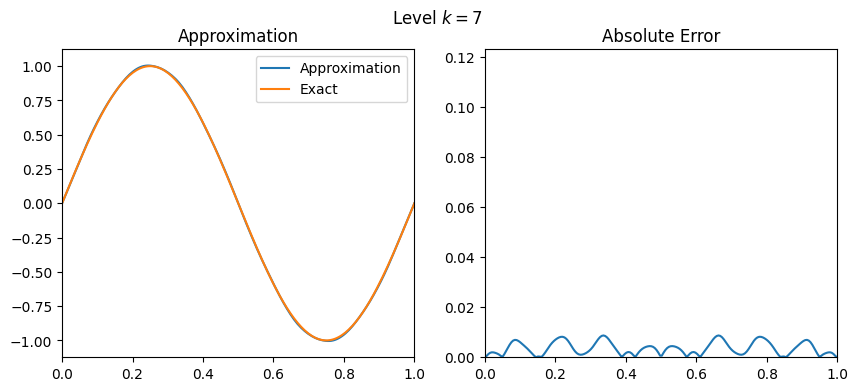

In [5]:
for i in range(1, len(approx) + 1):
    x = rad.gridn(ranges, 200)
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 4))
    plt.suptitle(f"Level $k = {i}$")
    axs[0].margins(x=0.)
    axs[1].margins(x=0.)

    axs[0].set_ylim(
            bottom=np.min(approx[:1](*x)) - plt.rcParams['axes.ymargin'],
            top=np.max(approx[:1](*x)) + plt.rcParams['axes.ymargin'],
        )
    axs[1].set_ylim(
        bottom=0.,
        top=np.max(
            np.abs(exact(*x) - approx[:1](*x))
        ) + plt.rcParams['axes.ymargin'],
    )
    
    axs[0].plot(*x, approx[:i](*x), label="Approximation")
    axs[0].plot(*x, exact(*x), label="Exact")

    axs[1].plot(*x, np.abs(exact(*x) - approx[:i](*x)))
    
    axs[0].set_title("Approximation")
    axs[1].set_title("Absolute Error")
    
    axs[0].legend()
    
    plt.savefig(f"figures/kansa-helmholtz-multilevel-{i}.pdf")

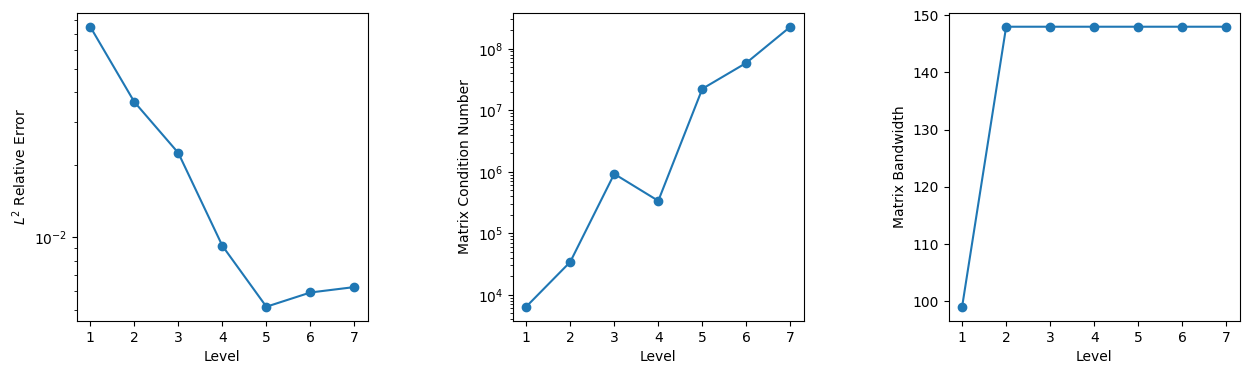

In [6]:
fig, axs = plt.subplots(1, 3, figsize=(15, 4))

idxs = range(1, levels+1)


axs[0].set_xlabel(r"Level")
axs[0].set_ylabel(r"$L^{2}$ Relative Error")
axs[0].set_yscale('log')
axs[0].set_xticks(idxs)
axs[0].plot(idxs, [rad.error(exact, approx[:i], error_integrator) for i in idxs], 'o-')

axs[1].set_xlabel(r"Level")
axs[1].set_ylabel("Matrix Condition Number")
axs[1].set_yscale('log')
axs[1].set_xticks(idxs)
axs[1].plot(idxs, solver.cond(), 'o-')

axs[2].set_xlabel(r"Level")
axs[2].set_ylabel("Matrix Bandwidth")
axs[2].set_xticks(idxs)
axs[2].plot(idxs, list(map(np.max, solver.bandwidth())), 'o-')

plt.subplots_adjust(wspace=0.5)
plt.savefig("figures/kansa-multilevel-data.pdf")